# Smiles Data To Memory Efficient Tfrecord (For GCS Bucket)
* Setup the following parameters:
    * **DATA_SMI='/path/to/some/dataset.smi'**
    * **TFRECORD_PATH='/folder/path/to/save/tfrecords/'**
    * **EVAL_SPLIT=fraction of data for validation**

In [1]:
DATA_SMI     = '/home/ansary/RESEARCH/nCov/pySMD/data/sample_dataset_c_34_128.smi' # @param
TFRECORD_PATH= '/home/ansary/RESEARCH/nCov/pySMD/data/tfrecSMDsample/'  # @param
EVAL_SPLIT   = 0.2


# Imports and Fixed Parameters

In [2]:
import os
import numpy as np
from rdkit import Chem
from tqdm.notebook import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
def create_dir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

# train and eval dir
TRAIN_DIR= os.path.join(TFRECORD_PATH,'Train')
EVAL_DIR = os.path.join(TFRECORD_PATH,'Eval')

create_dir(TFRECORD_PATH)
create_dir(TRAIN_DIR)
create_dir(EVAL_DIR)

# Sample Data Visualization

Total Smile Data: 438552
Smile Example Data: O=C1Nc2cc(NC(=O)c3c[nH]cc(-c4ccc(C(F)(F)F)cc4)c3=O)ccc2C1=Cc1ccc[nH]1


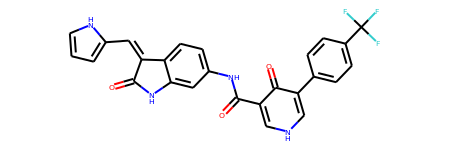

In [3]:
with open(DATA_SMI) as f:
    smiles = [s.rstrip() for s in f]
print('Total Smile Data:',len(smiles))    
print('Smile Example Data:',smiles[0])   
molecule=Chem.MolFromSmiles(smiles[0])
molecule

# Tokenizer Class
* The tokenizer class is kept as same as the  State Of The Art **LSTM_Chem** : **smiles_tokenizer** 
**[SOURCE]( https://github.com/topazape/LSTM_Chem/blob/b469e6aff2df28de99b9c4541a1a76d4d4fd77b0/lstm_chem/utils/smiles_tokenizer2.py)**

In [4]:
class SmilesTokenizer(object):
    def __init__(self):
        atoms = ['Al', 'As', 'B', 'Br', 'C', 'Cl', 
                 'F', 'H', 'I', 'K', 'Li', 'N',
                 'Na', 'O', 'P', 'S', 'Se', 'Si', 'Te']
        special = ['(', ')', '[', ']', '=', '#', '%', '0', '1', '2', '3', '4', '5',
            '6', '7', '8', '9', '+', '-', 'se', 'te', 'c', 'n', 'o', 's']
        padding = ['G', 'A', 'E']

        self.table = sorted(atoms, key=len, reverse=True) + special + padding
        table_len = len(self.table)

        self.table_2_chars = list(filter(lambda x: len(x) == 2, self.table))
        self.table_1_chars = list(filter(lambda x: len(x) == 1, self.table))

        self.one_hot_dict = {}
        for i, symbol in enumerate(self.table):
            vec = np.zeros(table_len, dtype=np.float32)
            vec[i] = 1
            self.one_hot_dict[symbol] = vec

    def tokenize(self, smiles):
        smiles = smiles + ' '
        N = len(smiles)
        token = []
        i = 0
        while (i < N):
            c1 = smiles[i]
            c2 = smiles[i:i + 2]

            if c2 in self.table_2_chars:
                token.append(c2)
                i += 2
                continue

            if c1 in self.table_1_chars:
                token.append(c1)
                i += 1
                continue

            i += 1

        return token

    def one_hot_encode(self, tokenized_smiles):
        result = np.array(
            [self.one_hot_dict[symbol] for symbol in tokenized_smiles],
            dtype=np.float32)
        result = result.reshape(1, result.shape[0], result.shape[1])
        return result

tokenizer=SmilesTokenizer()

# Tfrecord utils
* one hot encodes the **tokenized-padded** smiles data
* encodes the data to **.png** format
* extacts the **bytes** and writes to **tfrecord**

In [5]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _int64_feature(value):
      return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _float_feature(value):
      return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def to_tfrecord(data,save_dir,r_num):
    tfrecord_name='{}.tfrecord'.format(r_num)
    tfrecord_path=os.path.join(save_dir,tfrecord_name)
    with tf.io.TFRecordWriter(tfrecord_path) as writer:    
        for tp_smi in data:
            # one_hot_encoding
            X = np.array([tokenizer.one_hot_dict[symbol] for symbol in tp_smi[:-1]],dtype=np.uint8)
            y = np.array([tokenizer.one_hot_dict[symbol] for symbol in tp_smi[1:]],dtype=np.uint8)
            # png encoded data
            _,X_coded = cv2.imencode('.png',X)
            _,y_coded = cv2.imencode('.png',y)
            # byte conversion
            x_bytes = X_coded.tobytes()
            y_bytes = y_coded.tobytes()
            # data_dict
            data_dict ={  'X':_bytes_feature(x_bytes),
                          'Y':_bytes_feature(y_bytes)}
            # writting to tfrecord
            features=tf.train.Features(feature=data_dict)
            example= tf.train.Example(features=features)
            serialized=example.SerializeToString()
            writer.write(serialized)   

# save the data as tfrecord
def create_records(_smiles,save_path,mode,BATCH_SIZE=10240):
    print('Saving The data to tfrecord:',mode)
    for i in  tqdm(range(0,len(_smiles),BATCH_SIZE)):
        data=_smiles[i:BATCH_SIZE+i]
        r_num=i//BATCH_SIZE
        to_tfrecord(data,save_path,r_num)

# Saving the data
* Tokenizing the smiles 
* Padding the tokenized smiles as per [LSTM_Chem:data_loader](https://github.com/topazape/LSTM_Chem/blob/b469e6aff2df28de99b9c4541a1a76d4d4fd77b0/lstm_chem/data_loader.py)
* Saving to tfrecords

In [6]:
# tokenizing the smiles
print('Tokenizing the smiles')
tokenized_smiles = [tokenizer.tokenize(smi) for smi in tqdm(smiles)]
# Get MaxLength of smiles 
print('Getting MaxLength of smiles')
SMI_MAX_LEN=0
for smi in tqdm(tokenized_smiles):
    _smi_len=len(smi)
    if _smi_len > SMI_MAX_LEN:
        SMI_MAX_LEN=_smi_len
# padding the smiles with max length 
print('Padding the smiles with max length')
padded_smiles = [['G'] + tokenized_smi + ['E']+
                 ['A' for _ in range(SMI_MAX_LEN -len(tokenized_smi))]
                 for tokenized_smi in tqdm(tokenized_smiles)]

# data Split
eval_data_len=int(len(padded_smiles)*EVAL_SPLIT)
train_smiles= padded_smiles[eval_data_len:]
eval_smiles = padded_smiles[:eval_data_len]

# saving records
create_records(train_smiles,TRAIN_DIR,'Train')
create_records(eval_smiles,EVAL_DIR,'Eval')



        

Tokenizing the smiles



Getting MaxLength of smiles



Padding the smiles with max length



Saving The data to tfrecord: Train



Saving The data to tfrecord: Eval


# But why use ".png" bytes instead of "float32" one hot encoded data?
* Simple Answer: **DataSize**

### Data Inspection

In [7]:
import sys

example_smile=smiles[0]
print('Example Smile:',example_smile)
print()
tokenized=tokenizer.tokenize(example_smile)
print('Tokenized Smile:',tokenized)
print()
padded=['G'] + tokenized + ['E']+ ['A' for _ in range(SMI_MAX_LEN -len(tokenized))]
print('Padded Smile:',padded)
X = np.array([tokenizer.one_hot_dict[symbol] for symbol in padded[:-1]])
y = np.array([tokenizer.one_hot_dict[symbol] for symbol in padded[1:]])
print('One hot Encoded Input Data:',X)
print()
print('Input Shape:',X.shape)
print()
print('One hot Encoded Target Data:',y)
print()
print('Target Shape:',y.shape)
print()
print('Input Size:',sys.getsizeof(X),' bytes')
print('Target Size:',sys.getsizeof(y),' bytes')
print('Approximate Total Space needed to store the data as it is:',
      round((2*len(padded_smiles)*sys.getsizeof(X))/10**9,2),'Giga bytes')



Example Smile: O=C1Nc2cc(NC(=O)c3c[nH]cc(-c4ccc(C(F)(F)F)cc4)c3=O)ccc2C1=Cc1ccc[nH]1

Tokenized Smile: ['O', '=', 'C', '1', 'N', 'c', '2', 'c', 'c', '(', 'N', 'C', '(', '=', 'O', ')', 'c', '3', 'c', '[', 'n', 'H', ']', 'c', 'c', '(', '-', 'c', '4', 'c', 'c', 'c', '(', 'C', '(', 'F', ')', '(', 'F', ')', 'F', ')', 'c', 'c', '4', ')', 'c', '3', '=', 'O', ')', 'c', 'c', 'c', '2', 'C', '1', '=', 'C', 'c', '1', 'c', 'c', 'c', '[', 'n', 'H', ']', '1']

Padded Smile: ['G', 'O', '=', 'C', '1', 'N', 'c', '2', 'c', 'c', '(', 'N', 'C', '(', '=', 'O', ')', 'c', '3', 'c', '[', 'n', 'H', ']', 'c', 'c', '(', '-', 'c', '4', 'c', 'c', 'c', '(', 'C', '(', 'F', ')', '(', 'F', ')', 'F', ')', 'c', 'c', '4', ')', 'c', '3', '=', 'O', ')', 'c', 'c', 'c', '2', 'C', '1', '=', 'C', 'c', '1', 'c', 'c', 'c', '[', 'n', 'H', ']', '1', 'E', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']
One hot Encoded Input Data: [[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0.

float32 Data visualization
Input


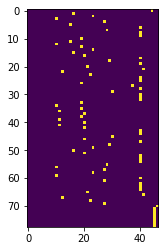

Data Sign: [0. 1.]
Target


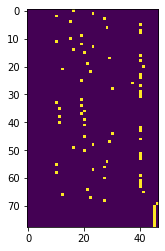

Data Sign: [0. 1.]
uint8 Data visualization
Input


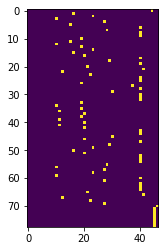

Data Sign: [0 1]
Target


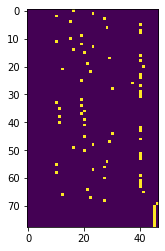

Data Sign: [0 1]


In [8]:
# Data as unit8
print('float32 Data visualization')
print('Input')
plt.imshow(X)
plt.show()
print('Data Sign:',np.unique(X))
print('Target')
plt.imshow(y)
plt.show()
print('Data Sign:',np.unique(y))

X=X.astype(np.uint8)
y=y.astype(np.uint8)

print('uint8 Data visualization')
print('Input')
plt.imshow(X)
plt.show()
print('Data Sign:',np.unique(X))
print('Target')
plt.imshow(y)
plt.show()
print('Data Sign:',np.unique(y))

In [9]:
# Png encoded data
_,X_coded = cv2.imencode('.png',X)
_,y_coded = cv2.imencode('.png',y)
# Byte conversion
x_bytes = X_coded.tobytes()
y_bytes = y_coded.tobytes()
print('Encoded bytes datasize:Input:',sys.getsizeof(x_bytes),' bytes')
print('Encoded bytes datasize:Target:',sys.getsizeof(y_bytes),' bytes')
print('Approximate Total Space needed to store the data in .png raw bytes:',
      round((2*len(padded_smiles)*sys.getsizeof(x_bytes))/10**9,2),'Giga bytes')


Encoded bytes datasize:Input: 363  bytes
Encoded bytes datasize:Target: 363  bytes
Approximate Total Space needed to store the data in .png raw bytes: 0.32 Giga bytes


# Data Pipeline Check

In [11]:
BATCH_SIZE=1024
BUFFER_SIZE=2048
DATA_DIM=(SMI_MAX_LEN+1,len(tokenizer.table))

def data_input_fn(data_path): 
    def _parser(example):
        feature ={  'X'  : tf.io.FixedLenFeature([],tf.string) ,
                    'Y'  : tf.io.FixedLenFeature([],tf.string)}    
        parsed_example=tf.io.parse_single_example(example,feature)
        inp=parsed_example['X']
        inp=tf.image.decode_png(inp,channels=1)
        inp=tf.cast(inp,tf.float32)
        inp=tf.reshape(inp,DATA_DIM)
        
        tgt=parsed_example['Y']
        tgt=tf.image.decode_png(tgt,channels=1)
        tgt=tf.cast(tgt,tf.float32)
        tgt=tf.reshape(tgt,DATA_DIM)
        
        return inp,tgt
    # get tfrecords from data_path
    _pattern=os.path.join(data_path,'*.tfrecord')
    # extract file paths
    file_paths = tf.io.gfile.glob(_pattern)
    # create data set with standard parsing,shuffling,batching and prefetching
    dataset = tf.data.TFRecordDataset(file_paths)
    dataset = dataset.map(_parser)
    dataset = dataset.shuffle(BUFFER_SIZE,reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

example_ds = data_input_fn(TRAIN_DIR)
for x,y in example_ds.take(1):
  print('Batched Input Data Shape:',x.shape)
  print('Batched Target Data Shape:',y.shape)
  print('Sample Input Data:',x[0])
  print('Sample Target Data:',x[0])

print()
print()
print()

print('The DATA_DIM variable for training:',DATA_DIM)

Batched Input Data Shape: (1024, 78, 47)
Batched Target Data Shape: (1024, 78, 47)
Sample Input Data: tf.Tensor(
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]], shape=(78, 47), dtype=float32)
Sample Target Data: tf.Tensor(
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]], shape=(78, 47), dtype=float32)



The DATA_DIM variable for training: (78, 47)


# Discussion
* After creating your own tfrecords you can upload it to your own bucket
* The sample data Access for this specific example is discussed in **README.md**